In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.dirname(sys.path[0]))
sys.path.append(PROJECT_ROOT)

from lsr_tensor import *
from lsr_bcd_regression import *
import torch
import torch.nn.functional as f
from datasets import *
from federated_algos import *
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from federated_tests import *
from medmnist import BreastMNIST
import cProfile
from torchvision import transforms

import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))

/home/fishcat/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Synthetic Data
shape, ranks, separation_rank = (64, 64), (8, 8), 2
loss_fn = f.mse_loss

sample_size = 2000
val_sample_size = 500

synth_dataset, synth_val_dataset = synthesize_data(shape, ranks, separation_rank,\
                                                   sample_size, val_sample_size)
synth_client_datasets = federate_dataset(synth_dataset, 10)
synth_data = (synth_dataset, synth_client_datasets, synth_val_dataset)

In [ ]:
# Breast MNIST
shape, ranks, separation_rank = (28, 28), (3, 3), 2
loss_fn = logistic_loss

transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float32)])

breast_dataset = BreastMNIST(split="train", download=True, transform=transform)
breast_client_datasets = federate_dataset(breast_dataset, 10)
breast_val_dataset = BreastMNIST(split="val", download=True, transform=transform)
breast_data = (breast_dataset, breast_client_datasets, breast_val_dataset)

print("fraction positive: ", sum(breast_val_dataset[:, 0][1]) / len(breast_val_dataset[:, 0][1]))

In [ ]:
path_base = "../data/breast_test_long"

In [3]:
iters = 100
n_workers = 2
n_runs = 5
path_base = "../data/synthetic_test"

dataset, client_datasets, val_dataset = synth_data
loss_fn = f.mse_loss
aggregator_fn = avg_aggregation
hypers = {"max_rounds": 1, "max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}

lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cpu'))

print("Centralized algorithm training")
path = f"{path_base}/centralized"
args = (lsr_bcd_regression, lsr_dot_params, loss_fn, dataset, val_dataset, hypers, False)

run_test(path, n_runs, n_workers, *args)

print("\nStepwise federated algorithm training...")
path = f"{path_base}/step"
args = (BCD_federated_stepwise, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

run_test(path, n_runs, n_workers, *args)

print("\nSplit factors + core federated algorithm training...")
path = f"{path_base}/factors_core"
args = (BCD_federated_all_factors, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

run_test(path, n_runs, n_workers, *args)

print("\n1 full iteration federated algorithm training...")
path = f"{path_base}/one_iter"
hypers["max_rounds"], hypers["max_iter"] = iters, 1
args = (BCD_federated_full_iteration, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

run_test(path, n_runs, n_workers, *args)

print("\n5 full iteration federated algorithm training...")
path = f"{path_base}/five_iter"
hypers["max_rounds"], hypers["max_iter"] = iters // 5, 5
args = (BCD_federated_full_iteration, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

run_test(path, n_runs, n_workers, *args)

Centralized algorithm training
Run 0
Run 1
Run 2
Run 3
Run 4

Stepwise federated algorithm training...
Run 0
Run 1
Run 2
Run 3
Run 4

Split factors + core federated algorithm training...
Run 0
Run 1
Run 2
Run 3
Run 4

1 full iteration federated algorithm training...
Run 0
Run 1
Run 2
Run 3
Run 4

5 full iteration federated algorithm training...
Run 0
Run 1
Run 2
Run 3
Run 4


In [5]:
#Load data from runs
names = ["centralized", "step", "factors_core", "one_iter", "five_iter"]
train_losses, train_std = [], []
val_losses, val_std = [], []

train_accs, train_acc_std = [], []
val_accs, val_acc_std = [], []

for name in names:
    path = f"{path_base}/{name}"
    train_losses.append(torch.mean(torch.load(f"{path}/train_loss"), axis=0))
    train_std.append(torch.std(torch.load(f"{path}/train_loss"), axis=0))
    
    val_losses.append(torch.mean(torch.load(f"{path}/val_loss"), axis=0))
    val_std.append(torch.std(torch.load(f"{path}/val_loss"), axis=0))

    #train_accs.append(torch.mean(torch.load(f"{path}/train_acc"), axis=0))
    #train_acc_std.append(torch.std(torch.load(f"{path}/train_acc"), axis=0))
    
    #val_accs.append(torch.mean(torch.load(f"{path}/val_acc"), axis=0))
    #val_acc_std.append(torch.std(torch.load(f"{path}/val_acc"), axis=0))
    
print("Loaded run data")

Loaded run data


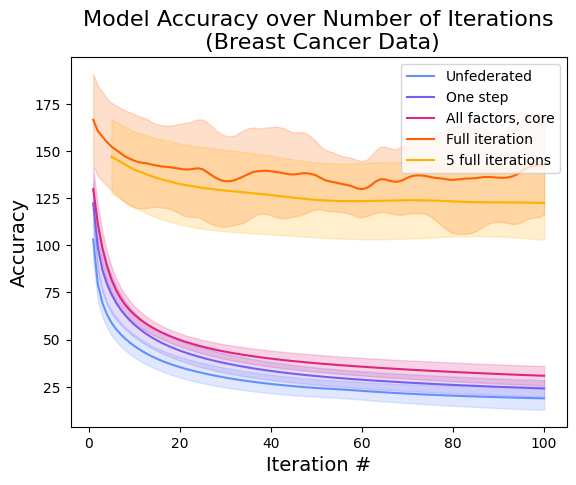

In [8]:
colors = ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"]
labels = ["Unfederated", "One step", "All factors, core", "Full iteration", "5 full iterations"]
xscales = [1, 1, 1, 1, 5]
metrics = val_losses
stds = val_std

#plt.figure(figsize=(5, 5))
for metric, std, xscale, label, color in zip(metrics, stds, xscales, labels, colors):
    plt.plot((np.arange(len(metric)) + 1)*xscale, metric, label=label, color=color)
    plt.fill_between((np.arange(len(metric)) + 1)*xscale, metric-std, metric+std, color=color, alpha=0.2)

plt.legend()
plt.xlabel("Iteration #", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Model Accuracy over Number of Iterations\n (Breast Cancer Data)", fontsize=16)
plt.show()

In [ ]:
print("Testing...")

hypers = {"max_rounds": 1, "max_iter": 100, "batch_size": None, "lr": 0.005, "momentum": 0.9, "steps": 10, "threshold": 0.0}
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))

init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
lsr_bcd_regression(init_lsr_dot, loss_fn, breast_dataset, breast_val_dataset,\
                       hypers, True, True)

print("Finished without errors")

In [ ]:
# Performance testing
print("Performance Testing...")
hypers = {"max_rounds": 1, "max_iter": 100, "batch_size": None, "lr": 0.005, "momentum": 0.9, "steps": 10, "threshold": 0.0}
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
cProfile.run("BCD_federated_stepwise(init_lsr_dot, synth_client_datasets, synth_val_dataset,\
              hypers, loss_fn, aggregator_fn, False)", sort='tottime')